# <center>${\textbf{Artificial Intelligence Decision Support System}}$<br>${\textbf{ for Groundwater Management under Climate Change:}}$</center><br><center>${\textbf{ Application to Mornag Region in Tunisia}}$</center><br><center>${\textbf{Old Data Modeling}}$</center>


${\textbf{Abstract}}$
The purpose of this research is to investigate the influence of climate change on GroundWater Level (GWL)  in  Mornag plain in Tunisia. Indeed, due to the spatiotemporal variability of RainFall (RF) and temperature, aquifers all over the world have seen significant water level volatility in recent decades. Therefore, for a reliable GroundWater (GW) management under climate change context, it is essential to analyze and estimate the GWL variability. In this study, we focus on the plain of Mornag, located in the southeast of Tunisia, since it contributes with 33% in the national agricultural production. From this plain, we have collected historical piezometric and RF data covering the period 2005-2015. Knowing the RF data, our goal is to forecast the GWL one. This issue has already been studied using classical numerical GW  modeling such as Modflow and Feflow. Unfortunately, these techniques are data and time consuming. To overcome all these drawbacks, we propose to use an Artificial Intelligence (AI) approach that  has shown great performance in literature for recurrent data modeling and forecasting. This approach corresponds to the Long-Short Term Memory (LSTM) Neural Network. Compared with Modflow, LSTM has shown noticeable enhancement in terms of root mean squared error minimization,  which confirms its  adequacy for GWL forecasting. Using the proposed AI prediction model, the impact of climate change on Mornag GWL has been studied under two Representative Concentration Pathway (RCP) scenarios; RCP 4.5 and RCP 8.5 for three future periods: 2015-2040 (short term), 2041-2065 (medium term) and 2066-2100 (long term). As expected, results reveal a future decline of Mornag GWL. The performed study of future Mornag GWL behavior using LSTM  could classify this AI approach  as a good decision support system that could be used to optimize the management of our limited water resources in order to satisfy the population needs in terms of drinking water and agricultural production, as well as to prevent upcoming drought.

<a id="libraries"></a>

${\textbf{Importing Libraries}}$

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import datetime 
import time

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import  GridSearchCV

import xgboost as xgb
from xgboost import plot_importance

In [2]:
Historical_Data = pd.read_pickle('./Pickles/HistoricalData/OldHistoricalData.pkl')

<a id="models"></a>

## ${\textbf{ Data Modelisation}}$

<a id="lstm"></a>

>${\textbf{LSTM:Long Short Term Memory}}$

In [3]:
df=Historical_Data.copy()
list_Year= [d.year for d in df.Time_RF]
list_Month= [d.month for d in df.Time_RF]
df['Month'] = list_Month
df['Year'] = list_Year

df.index=df.Time_RF
del df['Time_RF']
del df['Time_PZ']
del df['Lat']
del df['RF']
del df['Lon']
del df['Lat_Pluviometer']
del df['Lon_Pluviometer']
# df[[col for col in df.columns if df[col].dtypes == object]] = df[[col for col in df.columns if df[col].dtypes == object]].astype('category')
lb_make = LabelEncoder()
df["Piezometer"] = lb_make.fit_transform(df["Piezometer"])
lb_make1 = LabelEncoder()
df["Pluviometer"] = lb_make1.fit_transform(df["Pluviometer"])
lb_make2 = LabelEncoder()
df["SPI_classes"] = lb_make2.fit_transform(df["SPI_classes"])

In [4]:
column=['Pz','Piezometer', 'Pluviometer', 'YearlyRF', 'SemestrialRF',
       'TrimestrialRF', 'MonthlyRF', 'Zone', 'SPI', 'SPI_classes', 'Month',
       'Year']#Reindexing
df=df.reindex(column, axis='columns')
df

,Pz,Piezometer,Pluviometer,YearlyRF,SemestrialRF,TrimestrialRF,MonthlyRF,Zone,SPI,SPI_classes,Month,Year
Time_RF,,,,,,,,,,,,
2005-01-09,53.433000,30,7,204.2,204.2,28.1,28.1,1,-0.236898,2,1,2005
2005-02-09,53.433000,30,7,204.2,204.2,28.1,28.1,1,-0.236898,2,2,2005
2005-03-09,53.433000,30,7,204.2,204.2,28.1,28.1,1,-0.236898,2,3,2005
2005-04-09,53.433000,30,7,204.2,204.2,28.1,28.1,1,-0.236898,2,4,2005
2005-05-09,53.433000,30,7,204.2,204.2,28.1,28.1,1,-0.236898,2,5,2005
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-27,44.770923,40,12,294.3,38.5,38.5,38.5,2,-0.236898,2,8,2015
2015-08-28,44.770923,40,12,294.3,38.5,38.5,38.5,2,-0.236898,2,8,2015
2015-08-29,44.770923,40,12,294.3,38.5,38.5,38.5,2,-0.236898,2,8,2015


In [5]:
df.columns

Index(['Pz', 'Piezometer', 'Pluviometer', 'YearlyRF', 'SemestrialRF',
       'TrimestrialRF', 'MonthlyRF', 'Zone', 'SPI', 'SPI_classes', 'Month',
       'Year'],
      dtype='object')

In [6]:
df.shape

(285480, 12)

In [7]:
test_split=round(len(df)*0.30)
test_split

85644

In [8]:
df_for_training=df[:-test_split]
df_for_testing=df[-test_split:]
print(df_for_training.shape)
print(df_for_testing.shape)

(199836, 12)
(85644, 12)


In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled=scaler.transform(df_for_testing)
df_for_training_scaled

array([[0.99796646, 0.69767442, 0.41176471, ..., 0.66666667, 0.        ,
        0.        ],
       [0.99796646, 0.69767442, 0.41176471, ..., 0.66666667, 0.09090909,
        0.        ],
       [0.99796646, 0.69767442, 0.41176471, ..., 0.66666667, 0.18181818,
        0.        ],
       ...,
       [0.29348088, 0.86046512, 0.76470588, ..., 0.66666667, 0.09090909,
        0.6       ],
       [0.29348088, 0.86046512, 0.76470588, ..., 0.66666667, 0.18181818,
        0.6       ],
       [0.29348088, 0.86046512, 0.76470588, ..., 0.66666667, 0.27272727,
        0.6       ]])

In [10]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)

trainX,trainY=createXY(df_for_training_scaled,30)
testX,testY=createXY(df_for_testing_scaled,30)

In [11]:
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)

trainX Shape--  (199806, 30, 12)
trainY Shape--  (199806,)


In [12]:
print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)

testX Shape--  (85614, 30, 12)
testY Shape--  (85614,)


In [13]:
print("trainX[0]-- \n",trainX[0])
print("trainY[0]-- ",trainY[0])

trainX[0]-- 
 [[0.99796646 0.69767442 0.41176471 0.12776776 0.37933083 0.12755334
  0.13438546 0.         0.         0.66666667 0.         0.        ]
 [0.99796646 0.69767442 0.41176471 0.12776776 0.37933083 0.12755334
  0.13438546 0.         0.         0.66666667 0.09090909 0.        ]
 [0.99796646 0.69767442 0.41176471 0.12776776 0.37933083 0.12755334
  0.13438546 0.         0.         0.66666667 0.18181818 0.        ]
 [0.99796646 0.69767442 0.41176471 0.12776776 0.37933083 0.12755334
  0.13438546 0.         0.         0.66666667 0.27272727 0.        ]
 [0.99796646 0.69767442 0.41176471 0.12776776 0.37933083 0.12755334
  0.13438546 0.         0.         0.66666667 0.36363636 0.        ]
 [0.99796646 0.69767442 0.41176471 0.12776776 0.37933083 0.12755334
  0.13438546 0.         0.         0.66666667 0.45454545 0.        ]
 [0.99796646 0.69767442 0.41176471 0.12776776 0.37933083 0.12755334
  0.13438546 0.         0.         0.66666667 0.54545455 0.        ]
 [0.99796646 0.69767442 0.4

In [14]:
trainX.shape[1],trainX.shape[2]

(30, 12)

In [15]:
# def build_model():
#     grid_model = Sequential()
#     grid_model.add(LSTM(50,return_sequences=True,input_shape=(30,12)))
#     grid_model.add(LSTM(50))
#     grid_model.add(Dropout(0.2))
#     grid_model.add(Dense(1))
#     grid_model.compile(loss = 'mse',optimizer = 'adam')
#     return grid_model
  
# grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))

# parameters = {'batch_size' : [10,20],
#               'epochs' : [30,50]
#              }

# grid_search  = GridSearchCV(estimator = grid_model,
#                             param_grid = parameters,
#                             cv = 2)

In [16]:
# start_time = time.time()
# grid_search = grid_search.fit(trainX,trainY)
# dt_timeLSTM= (time.time() - start_time)
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 


In [17]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(30,12),recurrent_regularizer='l1_l2'))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss=root_mean_squared_error, optimizer='adam',metrics=['accuracy'])
start_time = time.time()
history=model.fit(trainX, trainY, epochs=8, batch_size=512,validation_data=(testX,testY))
dt_timeLSTM= (time.time() - start_time)

Epoch 1/8
391/391 [==============================] - 9s 13ms/step - loss: 0.7948 - accuracy: 0.0054 - val_loss: 0.0313 - val_accuracy: 0.0000e+00
Epoch 2/8
391/391 [==============================] - 4s 11ms/step - loss: 0.0408 - accuracy: 0.0055 - val_loss: 0.0264 - val_accuracy: 0.0000e+00
Epoch 3/8
391/391 [==============================] - 4s 11ms/step - loss: 0.0363 - accuracy: 0.0055 - val_loss: 0.0251 - val_accuracy: 0.0000e+00
Epoch 4/8
391/391 [==============================] - 5s 12ms/step - loss: 0.0334 - accuracy: 0.0055 - val_loss: 0.0237 - val_accuracy: 0.0000e+00
Epoch 5/8
391/391 [==============================] - 4s 11ms/step - loss: 0.0315 - accuracy: 0.0055 - val_loss: 0.0231 - val_accuracy: 0.0000e+00
Epoch 6/8
391/391 [==============================] - 4s 11ms/step - loss: 0.0307 - accuracy: 0.0055 - val_loss: 0.0233 - val_accuracy: 0.0000e+00
Epoch 7/8
391/391 [==============================] - 4s 11ms/step - loss: 0.0298 - accuracy: 0.0055 - val_loss: 0.0244 - val

In [18]:
dt_timeLSTM

39.72429943084717

In [19]:
prediction=history.model.predict(testX)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

2676/2676 [==============================] - 9s 3ms/step
prediction
 [[0.29550725]
 [0.2952548 ]
 [0.29496077]
 ...
 [0.86184096]
 [0.8615543 ]
 [0.8615301 ]]

Prediction Shape- (85614, 1)


In [20]:
prediction_copies_array = np.repeat(prediction,12, axis=-1)

In [21]:
prediction_copies_array.shape

(85614, 12)

In [22]:
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),12)))[:,0]

In [23]:
original_copies_array = np.repeat(testY,12, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),12)))[:,0]

In [24]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- " ,original)

Pred Values--  [ 5.07198   5.0546    5.034357 ... 44.061398 44.041664 44.039997]

Original Values--  [ 4.93247368  4.93247368  4.93247368 ... 44.77092308 44.77092308
 44.77092308]


In [25]:
np.sqrt(mean_squared_error(pred,original))

0.7459242932532619

In [26]:
print(history.history)
print(history.history.keys())

{'loss': [0.7947871088981628, 0.04081392660737038, 0.036260802298784256, 0.03342805802822113, 0.031484853476285934, 0.030748214572668076, 0.02977105788886547, 0.02941046841442585], 'accuracy': [0.005385223776102066, 0.005500335246324539, 0.005500335246324539, 0.005500335246324539, 0.005500335246324539, 0.005500335246324539, 0.005500335246324539, 0.005500335246324539], 'val_loss': [0.03132588043808937, 0.026446398347616196, 0.025098765268921852, 0.023672686889767647, 0.023053988814353943, 0.023285970091819763, 0.024361537769436836, 0.021287396550178528], 'val_accuracy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


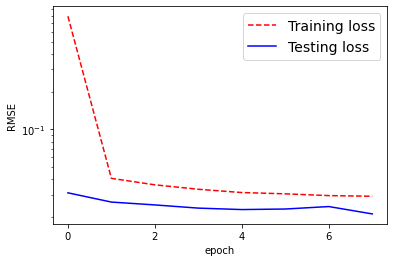

In [27]:
# list all data in history
# print(history.history.keys())
# summarize history for loss

plt.plot(history.history['loss'],'r--', label='Training loss')
plt.plot(history.history['val_loss'] ,'b', label='Testing loss')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.rcParams['font.size'] = '14'
plt.yscale('log')
plt.legend(['Training loss', 'Testing loss'] ,loc=0)
plt.show()

In [28]:
history.model.save('./../Pickles/Models/OldLSTM.h5')
np.save('./../Pickles/Models/Oldhistory.npy',history.history)

# history=np.load('my_history.npy',allow_pickle='TRUE').item()
# Recreate the exact same model, including its weights and the optimizer
# new_model = tf.keras.models.load_model('my_modelLSTM.h5')

# # Show the model architecture
# new_model.summary()

In [29]:
Test=pd.DataFrame()
Test["Piezometer"]=Historical_Data.Piezometer.sample(85614)
Test["Actual"]=original
Test["Predicted"]=pred
RMSE=np.sqrt(mean_squared_error(Test.Actual,Test.Predicted))

print(f' Global Root Mean Square Error (RMSE): {np.round(RMSE, 2)}')

 Global Root Mean Square Error (RMSE): 0.75


In [30]:
piezo=Test['Piezometer'].unique()
b = []#Dictionary
Global=0
for i in range(0,len(piezo)):
    RMSE=np.sqrt(mean_squared_error(Test.Actual[Test.Piezometer==piezo[i]],Test.Predicted[Test.Piezometer==piezo[i]]))
    print(f'Piezometer '+ str(i) + ': '+piezo[i]+f' : Root Mean Square Error (RMSE): {np.round(RMSE, 2)}')
    Global+=RMSE
    b.append(
        {
            'Piezometer':piezo[i],
            'RMSE':  RMSE
        }
    )   
rmseData=pd.DataFrame(b)#Create a dataframe from the dict
Global

Piezometer 0: Ali El Almi : Root Mean Square Error (RMSE): 0.41
Piezometer 1: Hachmi Allagui : Root Mean Square Error (RMSE): 0.69
Piezometer 2: Delagi : Root Mean Square Error (RMSE): 0.81
Piezometer 3: Mohamed Ben Nouiji : Root Mean Square Error (RMSE): 0.74
Piezometer 4: Ben Zazia : Root Mean Square Error (RMSE): 0.69
Piezometer 5: UCP Ouzra : Root Mean Square Error (RMSE): 0.82
Piezometer 6: Ben Saad : Root Mean Square Error (RMSE): 0.54
Piezometer 7: Puits public_6582 : Root Mean Square Error (RMSE): 0.83
Piezometer 8: Salah Khamar : Root Mean Square Error (RMSE): 0.56
Piezometer 9: El Attar : Root Mean Square Error (RMSE): 0.74
Piezometer 10: Ali et Med Bel Arbi : Root Mean Square Error (RMSE): 0.86
Piezometer 11: UCP Errissala_B : Root Mean Square Error (RMSE): 0.47
Piezometer 12: Mohamed Boutnini : Root Mean Square Error (RMSE): 0.9
Piezometer 13: Bel Hassen Sahli : Root Mean Square Error (RMSE): 0.93
Piezometer 14: Fraj : Root Mean Square Error (RMSE): 0.68
Piezometer 15: Huri

33.149490727345835

In [31]:
Global/44

0.7533975165305872

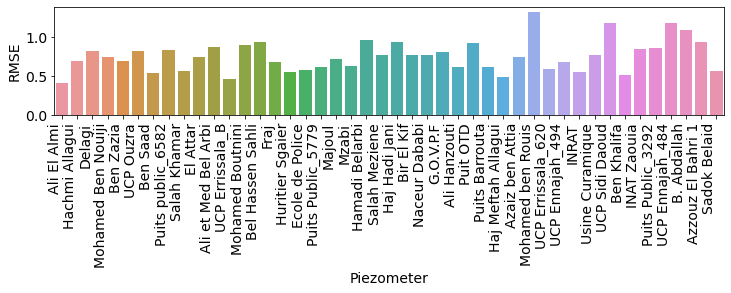

In [32]:
plt.figure(figsize=(12,2))

FIG=sns.barplot(x = 'Piezometer',
            y = 'RMSE',
            data = rmseData)
# Show the plot
FIG.set_xticklabels(FIG.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')
plt.show()